In [2]:
import os
from itertools import groupby
import json
import numpy as np
from skimage.draw import polygon
import pandas as pd
import plotnine


In [3]:
csv_path = "./instance_polygon_347.csv"

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df

Unnamed: 0      id                                             result  \
0              0  118167  [{"id": "iQuQSzTKL-", "type": "polygonlabels",...   
1              1  120694  [{"id": "H3K23-fqo5", "type": "polygonlabels",...   
2              2  120737  [{"id": "9m3BetKN0v", "type": "polygonlabels",...   
3              3  123613  [{"id": "sosxf3slzg", "type": "polygonlabels",...   
4              4  124572  [{"id": "XkPm9vitch", "type": "polygonlabels",...   
...          ...     ...                                                ...   
1065        1065  130151  [{"id": "qKORpmTKjT", "type": "polygonlabels",...   
1066        1066  130153  [{"id": "i2Tb0COuCq", "type": "polygonlabels",...   
1067        1067  130160  [{"id": "cua-G6F1y5", "type": "polygonlabels",...   
1068        1068  130164  [{"id": "HA4zPX0YiU", "type": "polygonlabels",...   
1069        1069  130166  [{"id": "tAcHKDT3Ee", "type": "polygonlabels",...   

      completed_by_id  lead_time  project_id  task_id  
0                 117    220.188         347   497644  
1                 186    126.908         347   497594  
2                 186    119.389         347   497610  
3                 200    159.034         347   497644  
4                 223     67.900         347   497644  
...               ...        ...         ...      ...  
1065              242     19.426         347   497646  
1066              242     27.902         347   497648  
1067              242     57.663         347   497650  
1068              242     38.841         347   497652  
1069              242     64.734         347   497654  

[1070 rows x 7 columns]

In [6]:
df_list = df.values.tolist()
df_list.sort(key=lambda x: x[6])
labels = []
for row in df_list:
    for anno in json.loads(row[2]):
        try:
            labels.append(anno["value"]["polygonlabels"][0])
        except KeyError:
            print("Task id: {}, id: {}".format(row[5], row[1]))
labels = list(set(labels))
labels.sort()
annotations = {}
image_size = {}
for task_id, results in groupby(df_list, key=lambda x: x[6]):
    result = dict(list(map(lambda x: (x[3], json.loads(x[2])), list(results))))
    annotations[task_id] = result
    image_size[task_id] = (list(result.values())[0][0]["original_height"], list(result.values())[0][0]["original_width"])

In [7]:
annotations

{497536: {131: [{'id': 'g6PBA3cgh1',
    'type': 'polygonlabels',
    'value': {'points': [[67.8125, 66.34304207119742],
      [63.28125, 68.6084142394822],
      [60.625, 77.3462783171521],
      [60.15625, 84.78964401294499],
      [61.5625, 90.93851132686085],
      [62.8125, 91.58576051779936],
      [61.5625, 85.76051779935275],
      [61.40625, 82.52427184466019],
      [65.15625, 79.6116504854369],
      [65.46875, 80.58252427184466],
      [64.53125, 91.2621359223301],
      [65.9375, 91.90938511326861],
      [67.34375, 86.08414239482201],
      [68.75, 91.90938511326861],
      [70.15625, 91.58576051779936],
      [69.84375, 83.49514563106796],
      [72.8125, 84.46601941747574],
      [73.28125, 87.70226537216828],
      [74.6875, 87.70226537216828],
      [75.3125, 88.67313915857605],
      [75.15625, 91.2621359223301],
      [76.71875, 92.23300970873787],
      [78.28125, 90.29126213592232],
      [77.1875, 86.73139158576052],
      [78.28125, 80.58252427184466],
      [78

In [11]:
segment_masks = []

for task_id in annotations:
    for uid in annotations[task_id]:
        for anno in annotations[task_id][uid]:
            try:
                orig_width = anno["original_width"]
                orig_height = anno["original_height"]
                points = anno["value"]["points"]
                points = np.array(points)
                points = (points * np.array([orig_width, orig_height])[np.newaxis, :]) / 100
                c, r = points.T
                rr, cc = polygon(r, c)
                label = anno["value"]["polygonlabels"][0]
                area = rr.shape[0] / (orig_width * orig_height)
                

                segment_masks.append({"task_id": task_id, "uid": uid, "label": label, "area": area, "points": points})
            except TypeError:
                continue

In [12]:
segment_masks

[{'task_id': 497536,
  'uid': 131,
  'label': 'elephant',
  'area': 0.03466322815533981,
  'points': array([[434., 205.],
         [405., 212.],
         [388., 239.],
         [385., 262.],
         [394., 281.],
         [402., 283.],
         [394., 265.],
         [393., 255.],
         [417., 246.],
         [419., 249.],
         [413., 282.],
         [422., 284.],
         [431., 266.],
         [440., 284.],
         [449., 283.],
         [447., 258.],
         [466., 261.],
         [469., 271.],
         [478., 271.],
         [482., 274.],
         [481., 282.],
         [491., 285.],
         [501., 279.],
         [494., 268.],
         [501., 249.],
         [502., 228.],
         [498., 217.],
         [485., 206.],
         [470., 201.],
         [448., 201.]])},
 {'task_id': 497536,
  'uid': 131,
  'label': 'elephant',
  'area': 0.06826456310679611,
  'points': array([[477., 155.],
         [464., 180.],
         [460., 199.],
         [478., 202.],
         [497., 2

In [13]:
segment_masks_df = pd.DataFrame(segment_masks)

In [14]:
segment_masks_df

task_id  uid     label      area  \
0      497536  131  elephant  0.034663   
1      497536  131  elephant  0.068265   
2      497536  118  elephant  0.070484   
3      497536  118  elephant  0.031776   
4      497536  117  elephant  0.078712   
...       ...  ...       ...       ...   
1959   497654   61       cow  0.010876   
1960   497654  233       cow  0.325632   
1961   497654  233       cow  0.084961   
1962   497654  242       cow  0.319144   
1963   497654  242       cow  0.089837   

                                                 points  
0     [[434.0, 205.0], [405.0, 212.0], [388.0, 239.0...  
1     [[477.0, 155.00000000000003], [464.0, 180.0], ...  
2     [[470.0, 171.0], [483.0, 154.0], [504.0, 154.0...  
3     [[497.0, 224.0], [495.0, 269.0], [501.0, 282.0...  
4     [[576.0, 252.0], [570.0, 278.0], [578.0, 283.0...  
...                                                 ...  
1959  [[545.9698661747311, 70.00704381432251], [549....  
1960  [[95.02683363148479, 46.968973747016705], [201...  
1961  [[476.2790697674419, 276.08591885441524], [456...  
1962  [[73.65079365079364, 45.714285714285715], [100...  
1963  [[474.920634920635, 264.12698412698415], [455....  

[1964 rows x 5 columns]

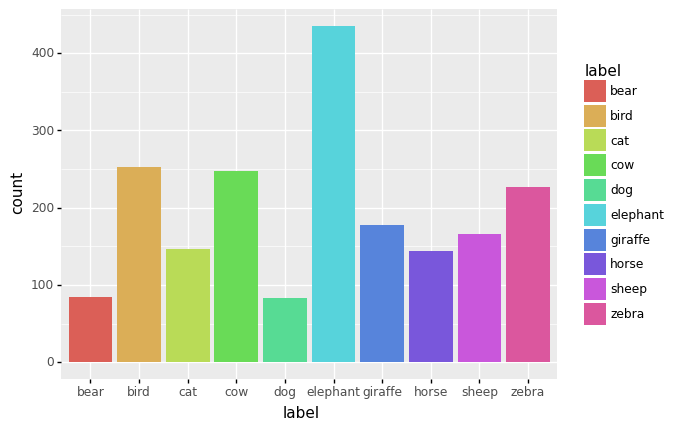

<ggplot: (138003920711)>

In [15]:
plotnine.ggplot(segment_masks_df) + plotnine.geom_bar(mapping=plotnine.aes(x="label", fill="label"))

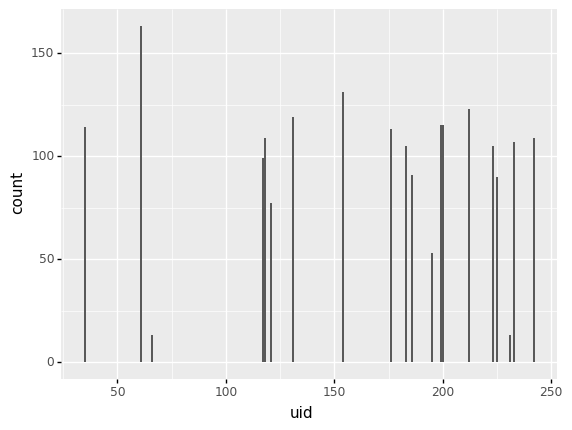

<ggplot: (-9223371898852041535)>

In [16]:
plotnine.ggplot(segment_masks_df) + plotnine.geom_bar(mapping=plotnine.aes(x="uid", fill="uid"))

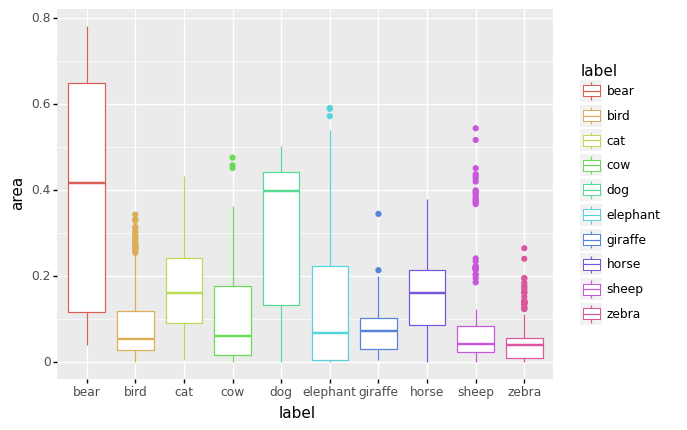

<ggplot: (138005455806)>

In [17]:
plotnine.ggplot(segment_masks_df) + plotnine.geom_boxplot(mapping=plotnine.aes(x="label", y="area", color="label"))